In [1]:
import pandas

비행기 승객 수 데이터를 연다.

`parse_dates`는 날짜로 처리할 컬럼을 지정한다

In [2]:
airline = pandas.read_csv('airline.csv', parse_dates=['Month'])

In [3]:
airline.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
airline['Month'].dtype

dtype('<M8[ns]')

## 시각화

In [5]:
import seaborn

C:\Users\eupho\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


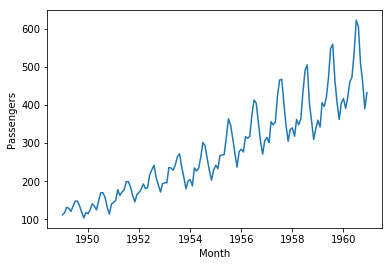

In [5]:
seaborn.lineplot('Month', 'Passengers', data=airline)

12개월 단위 이동평균

In [21]:
airline['Passengers'].rolling(window = 12).mean()

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
139    463.333333
140    467.083333
141    471.583333
142    473.916667
143    476.166667
Name: Passengers, Length: 144, dtype: float64

이동평균(Moving Average, Rolling Mean)을 빨간색으로 덧그린다

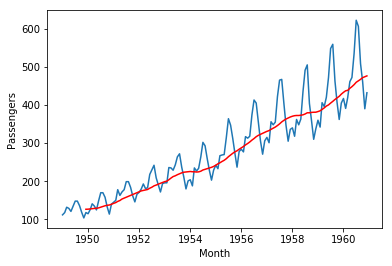

In [6]:
seaborn.lineplot('Month', 'Passengers', data=airline)
seaborn.lineplot(
    airline['Month'], 
    airline['Passengers'].rolling(window = 12).mean(),
    color='red')

## ACF

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

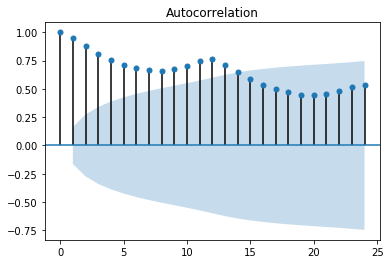

In [10]:
fig = plot_acf(airline['Passengers'], lags=24) # 24개월 ACF

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

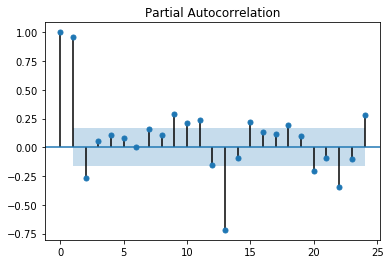

In [13]:
fig = plot_pacf(airline['Passengers'], lags=24)

## 정상성 검정 Augmented Dickey-Fuller Test

- p < .05 정상

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
result = adfuller(airline['Passengers'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411


## 로그 변환과 차분

In [6]:
import numpy

In [18]:
x = airline['Passengers'].values
x = numpy.log(x)  # 로그 변환 

In [19]:
diff = x[1:] - x[:-1]  # 차분

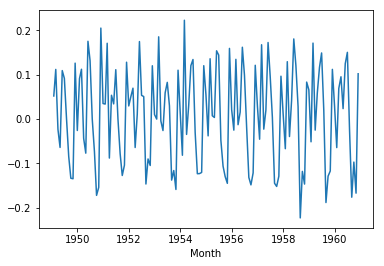

In [20]:
seaborn.lineplot(
    airline.iloc[1:, 0],
    diff)
    

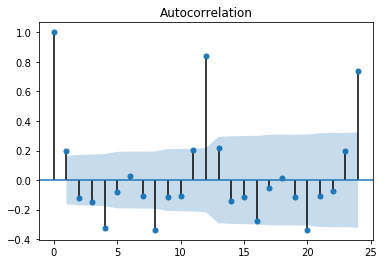

In [23]:
fig = plot_acf(diff, lags=24)

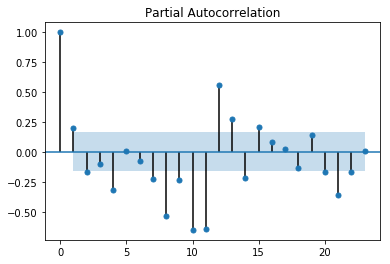

In [24]:
fig = plot_pacf(diff, lags=23)

In [25]:
result = adfuller(diff)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -2.7171305983881595
p-value: 0.07112054815085424


## SARIMA

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

데이터를 마지막 24개월 어치를 테스트용으로 잘라둔다

In [8]:
x_train = airline.iloc[:-24, 1]
x_test = airline.iloc[-24:, 1] 

In [14]:
res = SARIMAX(
    x_train, 
    order=(1, 1, 0), 
    seasonal_order=(12, 0, 1, 3),
).fit()

C:\Users\eupho\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(12, 0, 1, 3)   Log Likelihood                -454.019
Date:                            Wed, 09 Oct 2019   AIC                            938.037
Time:                                    16:27:03   BIC                            979.724
Sample:                                         0   HQIC                           954.965
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2700      0.103     -2.623      0.009      -0.472      -0.068
ar.S.L3        0.2756      1.131      0.244      0.808      -1.942       2.493
ar.S.L6        0.0523      0.276      0.189      0.850      -0.489       0.594
ar.S.L9        0.0003      0.153      0.002      0.998      -0.299       0.300
ar.S.L12       0.9656      0.124      7.769      0.000       0.722       1.209
ar.S.L15      -0.1991      1.040     -0.191      0.848      -2.237       1.839
ar.S.L18      -0.1046      0.352     -0.297      0.766      -0.794       0.585
ar.S.L21      -0.1027      0.183     -0.562      0.574      -0.461       0.256
ar.S.L24       0.1283      0.195      0.658      0.510      -0.254       0.511
ar.S.L27      -0.0547      0.151     -0.363      0.717      -0.350       0.241
ar.S.L30       0.0387      0.171      0.226      0.821      -0.297       0.374
ar.S.L33       0.0530      0.151      0.352      0.725      -0.242       0.348
ar.S.L36      -0.1366      0.152     -0.901      0.368      -0.434       0.161
ma.S.L3       -0.4592      1.087     -0.422      0.673      -2.591       1.672
sigma2        99.6027     17.669      5.637      0.000      64.972     134.234
===================================================================================
Ljung-Box (Q):                       46.26   Jarque-Bera (JB):                 2.98
Prob(Q):                              0.23   Prob(JB):                         0.23
Heteroskedasticity (H):               2.79   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

테스트용으로 잘라둔 마지막 24개월치를 예측

In [12]:
n = len(x_train)
m = len(x_test)
forecast = res.predict(n + 1, n+m)

C:\Users\eupho\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


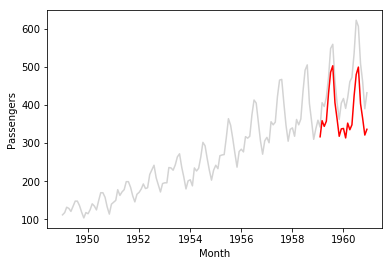

In [13]:
seaborn.lineplot('Month', 'Passengers', data=airline, color='lightgrey')
seaborn.lineplot(
    airline.iloc[-24:, 0],
    forecast,
    color='red'
)

In [36]:
from sklearn.metrics import mean_squared_error

In [38]:
mean_squared_error(x_test, forecast)  # 오차 제곱의 평균

1630.6312541454256

## Facebook Prophet

### 설치

In [62]:
!conda install -y -c conda-forge fbprophet

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\eupho\Anaconda3

  added / updated specs:
    - pystan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cython-0.29.13             |   py37ha925a31_0         1.8 MB
    libpython-2.1              |           py37_0          47 KB
    m2w64-binutils-2.25.1      |                5        44.3 MB
    m2w64-bzip2-1.0.6          |                6         100 KB
    m2w64-crt-git-5.0.0.4636.2595836|                2         3.4 MB
    m2w64-gcc-5.3.0            |                6        41.1 MB
    m2w64-gcc-ada-5.3.0        |                6        33.5 MB
    m2w64-gcc-fortran-5.3.0    |                6        10.3 MB
    m2w64-gcc-objc-5.3.0       |                6        15.1 MB
    m2w64-headers-git-5.0.0.4636.c0ad18a|                2         5.6 MB
    m2w64-isl-0.16.1           |         

### 예측

In [20]:
from fbprophet import Prophet

In [21]:
df = airline.iloc[:-24, :].copy()

prophet은 컬럼 이름을 날짜는 ds, 숫자 부분은 y로 고정

In [22]:
df.columns = ['ds', 'y']

In [23]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future = pandas.DataFrame({'ds': airline['Month'].values})

In [25]:
pp = m.predict(future)

In [26]:
pp.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,108.679074,64.342881,111.101544,108.679074,108.679074,-20.214792,-20.214792,-20.214792,-20.214792,-20.214792,-20.214792,0.0,0.0,0.0,88.464282
1,1949-02-01,110.845962,57.333189,107.616442,110.845962,110.845962,-27.687011,-27.687011,-27.687011,-27.687011,-27.687011,-27.687011,0.0,0.0,0.0,83.158951
2,1949-03-01,112.803150,94.477253,142.135337,112.803150,112.803150,4.780092,4.780092,4.780092,4.780092,4.780092,4.780092,0.0,0.0,0.0,117.583242
3,1949-04-01,114.970037,86.969862,133.533353,114.970037,114.970037,-4.864116,-4.864116,-4.864116,-4.864116,-4.864116,-4.864116,0.0,0.0,0.0,110.105922
4,1949-05-01,117.067025,88.350111,134.305098,117.067025,117.067025,-5.764061,-5.764061,-5.764061,-5.764061,-5.764061,-5.764061,0.0,0.0,0.0,111.302964


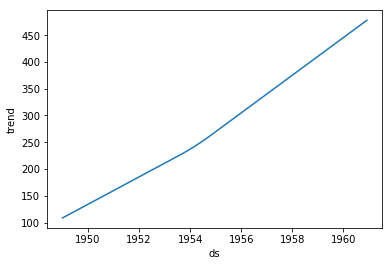

In [27]:
seaborn.lineplot('ds', 'trend', data=pp)

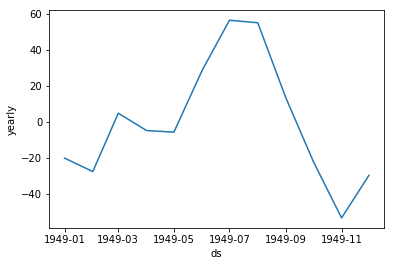

In [31]:
seaborn.lineplot('ds', 'yearly', data=pp.iloc[:12])

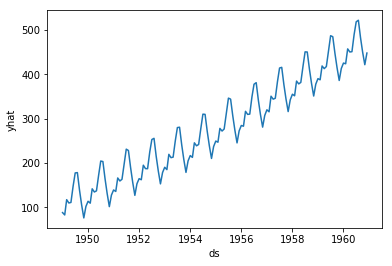

In [32]:
seaborn.lineplot('ds', 'yhat', data=pp)

In [33]:
forecast = pp['yhat'].values[-24:]

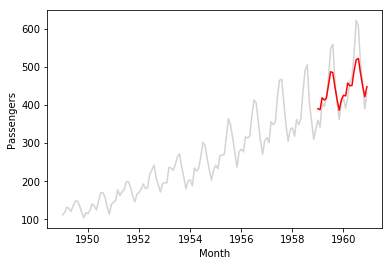

In [34]:
seaborn.lineplot('Month', 'Passengers', data=airline, color='lightgrey')
seaborn.lineplot(
    airline.iloc[-24:, 0],
    forecast,
    color='red'
)

In [37]:
mean_squared_error(x_test, forecast)

1630.6312541454256

In [39]:
import numpy

### R제곱

In [44]:
1 - mean_squared_error(x_test, forecast) / numpy.var(x_test)

0.707598596093931